# Degaussing Image with Known Blur Parameters
## By: Mason Nolan
---

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# Blur kernel size (change this here)
kernel_size = 11

# Motion blur angle (do not change)
min_angle = 0
max_angle = 180

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
# Motion blur generation routines
def create_motion_blur_kernel(size, angle):
  kernel = np.zeros((size, size), dtype=np.float32)
  center = (size - 1) / 2.0

  radian_angle = np.deg2rad(angle)
  dx = np.cos(radian_angle)
  dy = np.sin(radian_angle)
  x1 = int(round(center - dx * center))
  y1 = int(round(center - dy * center))
  x2 = int(round(center + dx * center))
  y2 = int(round(center + dy * center))

  cv2.line(kernel, (x1, y1), (x2, y2), 1.0, thickness=1)

  kernel[kernel < 0] = 0
  kernel_sum = kernel.sum()
  if kernel_sum == 0:
    kernel[int(center), int(center)] = 1.0
  else:
    kernel /= kernel_sum

  return kernel


def add_motion_blur(images, ksize, min_angle, max_angle, seed=123):

    blurred_images = np.zeros_like(images, dtype=np.float32)
    rng = np.random.RandomState(seed)

    for i in range(len(images)):

        image = images[i]

        # Parameters of motion blur kernel
        if ksize % 2 == 0:
            ksize += 1
        angle = rng.uniform(min_angle, max_angle)

        # Create motion blur kernel
        kernel = create_motion_blur_kernel(ksize, angle)

        # Apply kernel
        blurred_img = cv2.filter2D(image, -1, kernel)

        # 5. Clip and store
        blurred_images[i] = np.clip(blurred_img, 0.0, 255.0)

    return blurred_images.astype(np.int16)

In [ ]:
x_train_blurred = add_motion_blur(x_train, kernel_size, min_angle, max_angle)
x_test_blurred = add_motion_blur(x_test, kernel_size, min_angle, max_angle)

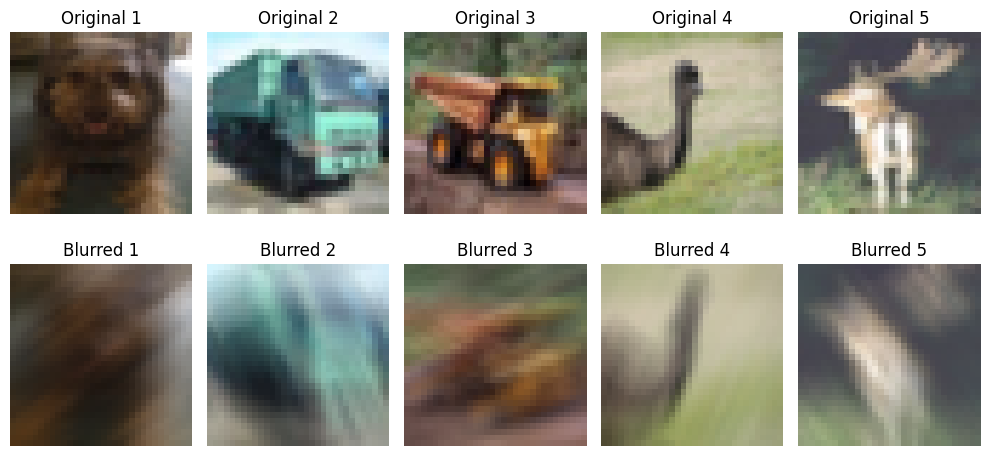

In [ ]:
# Visualize some of the blurred data along with the original data
def visualize_blurring(x_orig, x_blurred, num_examples=5):

  num_examples = min(num_examples, len(x_blurred))
  indices = np.random.choice(len(x_blurred), num_examples, replace=False)
  sample_orig = x_orig[indices]
  sample_blurred = x_blurred[indices]

  plt.figure(figsize=(num_examples * 2, 5))
  for i in range(num_examples):

    ax = plt.subplot(2, num_examples, i + 1)
    plt.imshow(sample_orig[i])
    plt.title(f"Original {i+1}")
    plt.axis("off")

    ax = plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(sample_blurred[i])
    plt.title(f"Blurred {i+1}")
    plt.axis("off")

  plt.tight_layout()
  plt.show()

# Visualize some of the blurred data
visualize_blurring(x_train, x_train_blurred, num_examples=5)

Now we can use the previous functions to produce 3 datasets of various degrees of gaussian blur.

In [ ]:
x_train_mild = add_motion_blur(x_train, 3, min_angle, max_angle) # We simply use the motion blur function and adjust the kernel size to the specified degrees for each level of blurredness.
x_test_mild = add_motion_blur(x_test, 3, min_angle, max_angle)
x_train_medium = add_motion_blur(x_train, 7, min_angle, max_angle)
x_test_medium = add_motion_blur(x_test, 7, min_angle, max_angle)
x_train_strong = add_motion_blur(x_train, 11, min_angle, max_angle)
x_test_strong = add_motion_blur(x_test, 11, min_angle, max_angle)

Mild blurring:


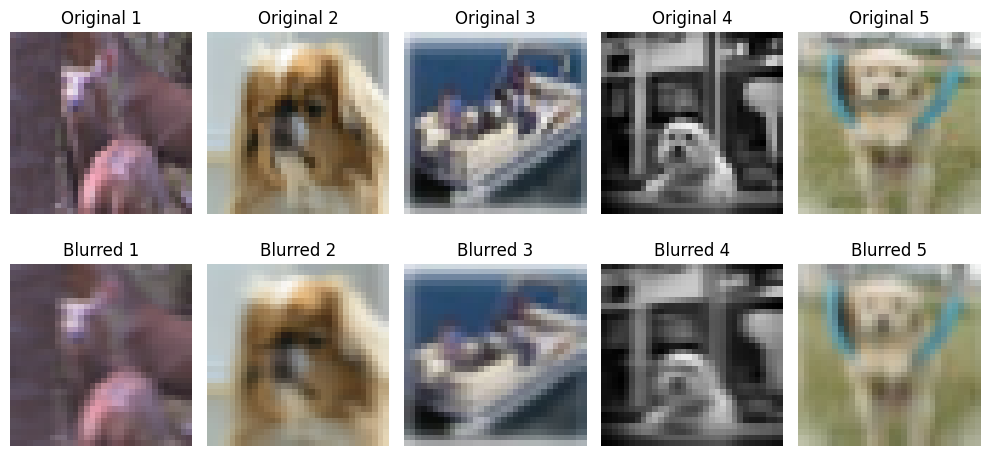


Medium blurring:


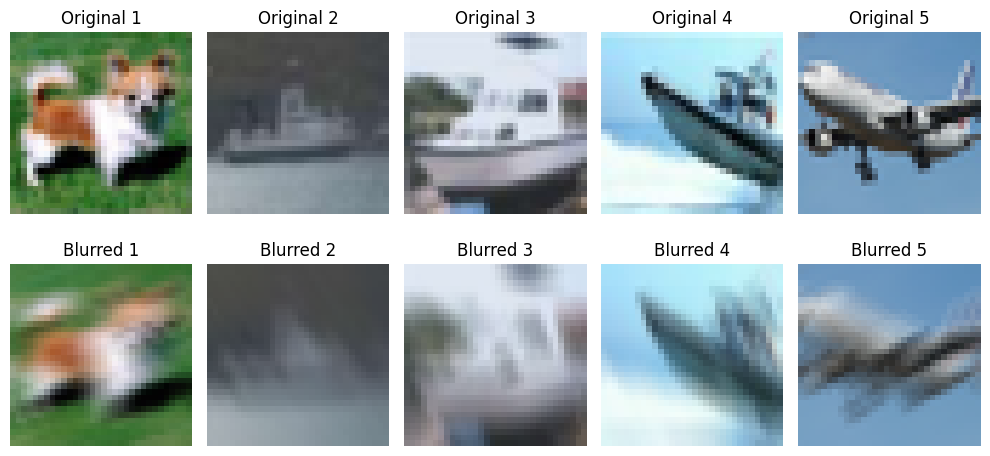


Strong blurring:


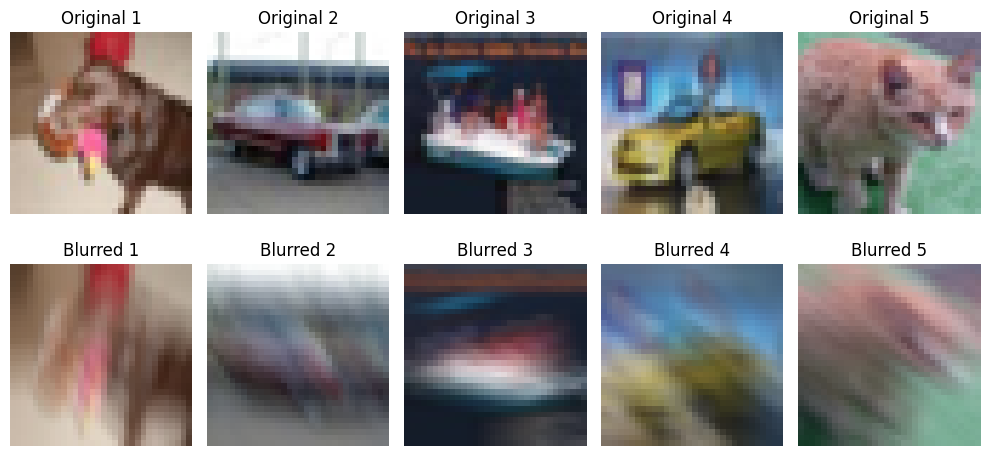

In [ ]:
print("Mild blurring:")
visualize_blurring(x_train, x_train_mild, num_examples=5)
print("\nMedium blurring:")
visualize_blurring(x_train, x_train_medium, num_examples=5)
print("\nStrong blurring:")
visualize_blurring(x_train, x_train_strong, num_examples=5)

We will now implement a model with the intent to remove guassian blur. A good idea for an architecture would be an EDSR architecture, which was found to be effective in a previous project for image reconstruction (superresolution), so we would expect such a model to also be effective at restoring damaged (blurred) images.

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
def ResBlock(x, filters=64, kernel_size=(3, 3), scale=0.1): # The ResBlock: does not incorporate batch normalization, and includes a residual scaling layer.

    residual = x
    conv1 = layers.Conv2D(filters, kernel_size, padding='same')(x)
    relu1 = layers.ReLU()(conv1)
    conv2 = layers.Conv2D(filters, kernel_size, padding='same')(relu1)
    residual = conv2*scale # Residual scaling with a (default) factor of 0.1.

    out = layers.add([x, residual]) # Addition

    return out

In [ ]:
def EDSR(num_residual_blocks=16, num_filters=64, image_size=(32, 32, 3)): # Image size matches our CIFAR-10 dimensions and RGB channels.

    inputs = layers.Input(shape=image_size)

    x = layers.Conv2D(num_filters, (3, 3), padding='same')(inputs)
    for _ in range(num_residual_blocks): # All of our ResBlocks between two convolution layers
        x = ResBlock(x, filters=num_filters)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)

    # x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x) --- In our assignment, we were using superresolution which upscaled the image. This layer is PixelShuffling upscaling, which is not necessary for our task.

    outputs = layers.Conv2D(3, (3, 3), padding='same')(x)
    model = models.Model(inputs, outputs)
    return model

In [ ]:
def ssim_metric(y_true, y_pred): # We have had issues in the past directly importing the SSIM and PSNR metric into our compiler, so we define the SSIM/PSNR metric function using the same operations and use that instead.
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    max_val = tf.reduce_max(tf.abs(y_true))
    max_val = tf.maximum(max_val, 1.0)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=max_val))

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    max_val = tf.reduce_max(tf.abs(y_true))
    max_val = tf.maximum(max_val, 1.0)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=max_val))

In [ ]:
model = EDSR(num_residual_blocks=16, num_filters=64)

model.compile(optimizer='adam', loss='mae', metrics=[ssim_metric, psnr_metric])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d[0][0],     │
│                     │ 64)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Multiply)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (Multiply)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ add_1[0][0],    

 Total params: 1,222,147 (4.66 MB)

 Trainable params: 1,222,147 (4.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train_medium, x_train, validation_data=(x_test_medium, x_test), batch_size=16, epochs=10) # Fit the model, using the medium blurred images as our inputs, and the clean images as our targets.

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 15.1776 - psnr_metric: 22.5907 - ssim_metric: 0.7244 - val_loss: 9.4358 - val_psnr_metric: 26.1290 - val_ssim_metric: 0.8687
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 8.9385 - psnr_metric: 26.6916 - ssim_metric: 0.8845 - val_loss: 7.4192 - val_psnr_metric: 28.4564 - val_ssim_metric: 0.9184
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 7.1365 - psnr_metric: 28.8108 - ssim_metric: 0.9265 - val_loss: 6.4010 - val_psnr_metric: 29.7726 - val_ssim_metric: 0.9374
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 6.3272 - psnr_metric: 29.9111 - ssim_metric: 0.9419 - val_loss: 6.2724 - val_psnr_metric: 30.0569 - val_ssim_metric: 0.9482
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 5.8760 - psnr_metric: 30.5804 - ssim_metric: 0.9503 - val_loss: 5.6550 - val_psnr_metric: 30.9208 - val_ssim_metric: 0.9538
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - l

We assess the generalizability of our model to heavily blurred or mildly blurred images. Of course, we could simply train a new model from the mild/strongly blurred images, but let's see how our current model performs at unblurring images of different blur amounts. We will modify our blur visualization function to view model-predicted unblurred images.

In [ ]:
# Visualize some of the blurred data along with the original data
def visualize_blurring_model(x_orig, x_blurred, num_examples=5):

  num_examples = min(num_examples, len(x_blurred))
  indices = np.random.choice(len(x_blurred), num_examples, replace=False)
  sample_orig = x_orig[indices]
  sample_blurred = x_blurred[indices]
  sample_unblurred = model.predict(sample_blurred)
  sample_unblurred = np.clip(sample_unblurred, 0, 255).astype(np.uint8) # Ensure that the predicted (unblurred) images numerical data is kept to the 0-255 range to keep proper color data.

  plt.figure(figsize=(num_examples * 3, 5))
  for i in range(num_examples):

    ax = plt.subplot(3, num_examples, i + 1)
    plt.imshow(sample_orig[i])
    plt.title(f"Original {i+1}")
    plt.axis("off")

    ax = plt.subplot(3, num_examples, i + 1 + num_examples)
    plt.imshow(sample_blurred[i])
    plt.title(f"Blurred {i+1}")
    plt.axis("off")

    ax = plt.subplot(3, num_examples, i + 1 + num_examples*2)
    plt.imshow(sample_unblurred[i])
    plt.title(f"Unblurred {i+1}")
    plt.axis("off")

  plt.tight_layout()
  plt.show()

Unblurring the mildly blurred images: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


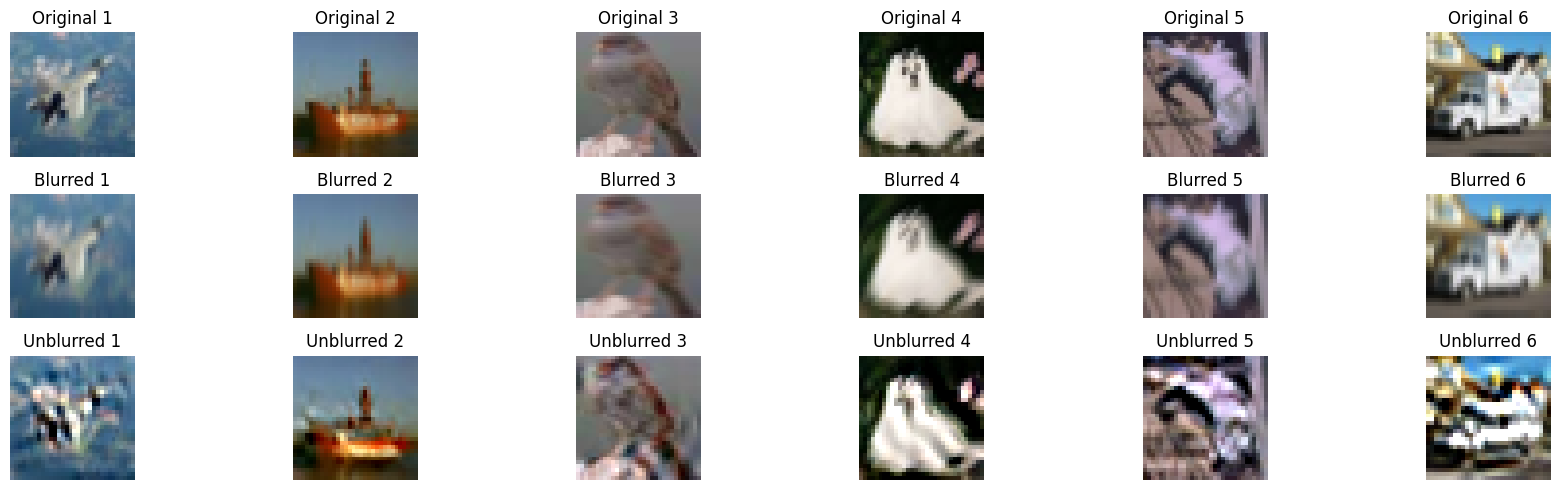


Unblurring the strongly blurred images: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


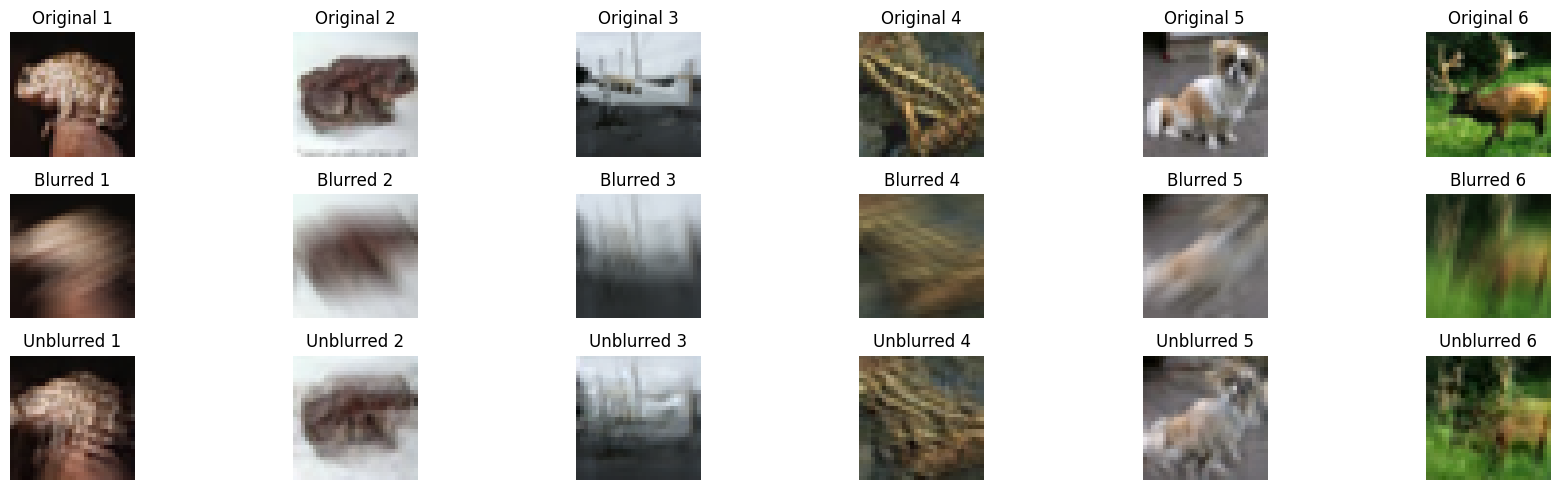

In [ ]:
print("Unblurring the mildly blurred images: ")
visualize_blurring_model(x_test, x_test_mild, num_examples=6)

print("\nUnblurring the strongly blurred images: ")
visualize_blurring_model(x_test, x_test_strong, num_examples=6)

We see that, although the model *is* able to unblur images that have been blurred by different magnitudes than the data the model was trained on, the images fail to properly capture many of the key features of the original images. Notably, the mildly blurred data was restored with increased saturation, heavy sharpness, and distorted edges. The heavily blurred data was restored without these issues, but not all of the blur was removed.

We suggest that our model is generalizable, but it is ideal to only use the model for unblurring images that were blurred with a kernel size close to our original training data (7). Images that are less blurry may overexaggerate features, and images taht are more blurry will fail to remove all blur.

On the other side, if we test our model on images of the same degree of blurredness as our training data, we get the following:


Unblurring the strongly blurred images: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


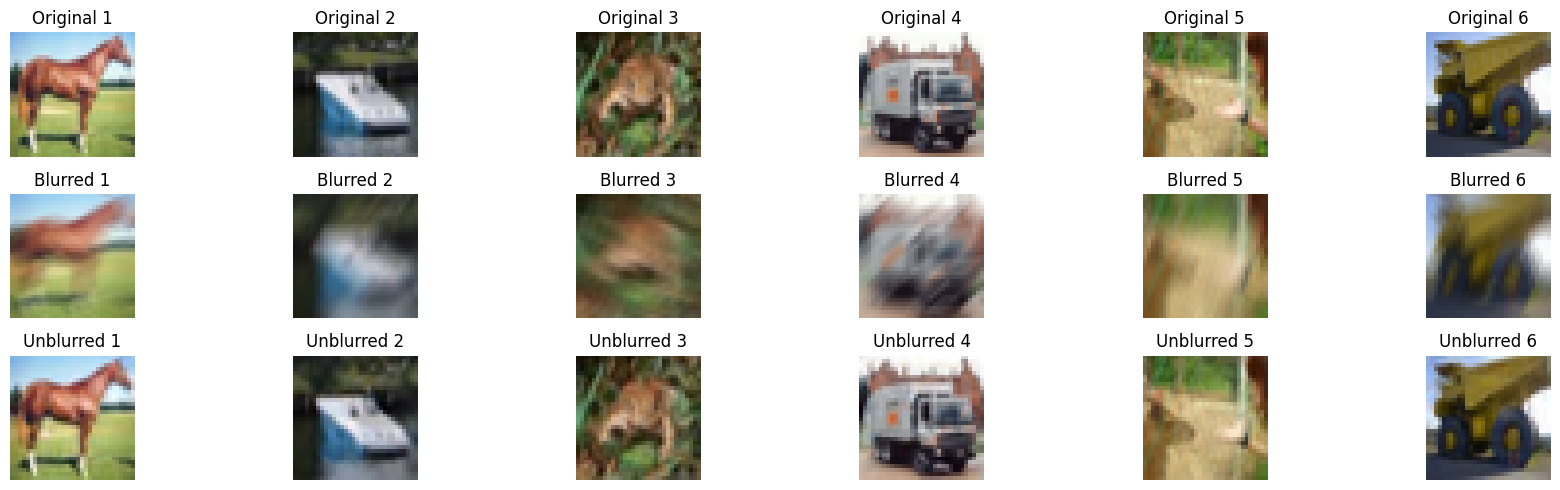

In [ ]:
print("\nUnblurring the strongly blurred images: ")
visualize_blurring_model(x_test, x_test_medium, num_examples=6)

We see that the model does an exceptional job at unblurring the images, and the unblurred images are almost indistinguishable from the originals.

We can now plot the metrics of our model since they were stored in the history at each epoch.

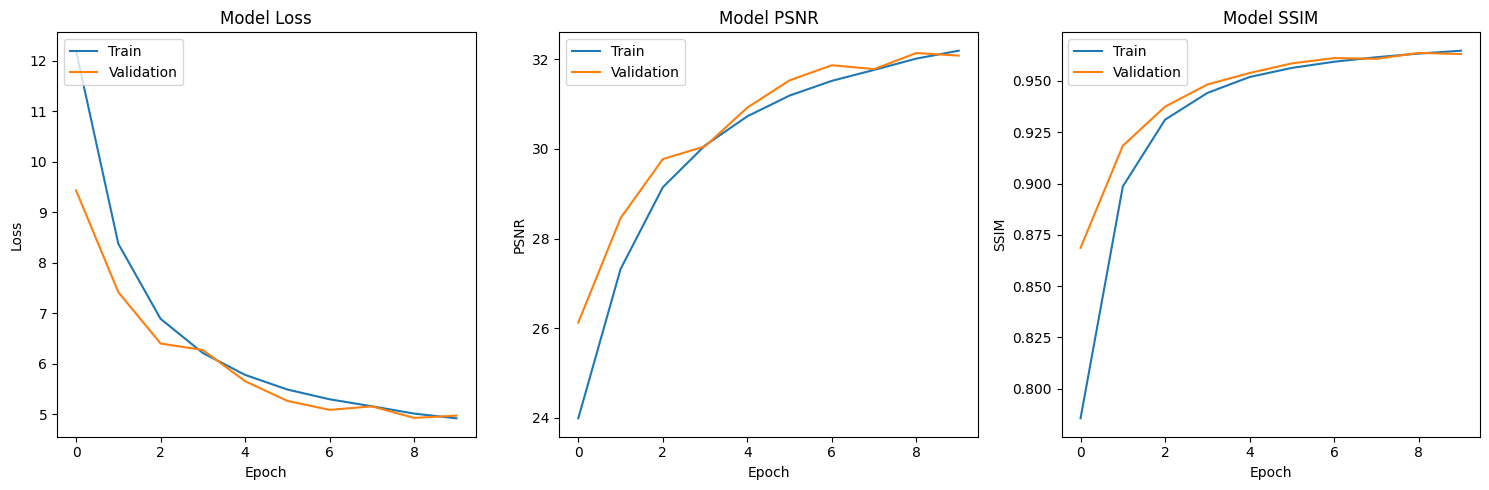

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation PSNR values
plt.subplot(1, 3, 2)
plt.plot(history.history['psnr_metric'])
plt.plot(history.history['val_psnr_metric'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation SSIM values
plt.subplot(1, 3, 3)
plt.plot(history.history['ssim_metric'])
plt.plot(history.history['val_ssim_metric'])
plt.title('Model SSIM')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Firstly we should note that none of our training/validation metrics fully tapered off, which suggests that our model is improvable by running more epochs (say, 5 or 10 more).

We see that our validation metrics are almost always better than our training data surprisingly enough, meaning there is essentially no sign of overfitting and our model generalizes greatly on unseen images (as long as they are blurred to a similar degree to our training images).

The model improved rapidly and required very few epochs to get promising results, for example, hitting almost a 92% validation SSIM benchmark with just 2 epochs. While our dataset was not overly complex, this does speak to the ability of our model to interpret the key features of our images quickly (which makes sense, seeing as our blurred images are obviously very closely related to the original images already).

Each metric, particularly SSIM, indicates an impressive result for reconstructing our images. The loss metric may be hard to interpret since the scale of the loss is proportional to the size of our images, so that is perhaps the only metric that is difficult to showcase as an achievement without comparison to similar models that are performing on the same dataset, or at least a dataset with the same image sizes.

---
Have a good year!